# This script contains EEG-EMG preprocessing for isokinetic rectangle movements 
## Synchronization infomation is obtained with matlab scripts, event engineering is done via interaction with EEGLAB
## EEG/EMG denoising (4 srg)
- exclude bads from subsequent processing
- filtering: 1-45Hz for EEG, 10-200Hz for EMG
- srg epochs generation with PTP thresholding
- ICA fitting and exclusion
- visual inspection: noisy epochs removal
## EEG/EMG denoising (4 motor trials)
## motor epochs identification
## data description:
- four motor patterns: up, right, down, left for right hands (i.e. clockwise); up, left, down, right for left hands (anticlockwise). We define them as **push**, horizontal abduction (**habd**), **pull**, and horizontal adduction (**hadd**)
- four CMN assessments with a week interval in between
- four groups: conventional therapy (subj51, 52), longterm 1Hz rTMS (subj43, 46, 47, 54, 55), longterm 10Hz rTMS (subj56, 57), longterm sham rTMS (subj42)
- two sorts of CMN: resting state FBC and task-related CMN
## 2 explore
- motor synergy (factorization thing)
- the effect of SPMI parameters
- iMC vs iVC, we see discontinuous EMG during iVC, so EMG envelop might be a compromised method. iMC paradigm is suitable for diagnosis. This concern can be addressed with muscle activation (smoother)
## Notes
- Channel 0-7 are valided EMG chs for most of the subjects. In some case, the recorded channels were not 0-7 because of technical hitches during the exp (subj56,57).


# Global definition

In [16]:
import mne
import pandas as pd
import os
import numpy as np
from mne.preprocessing import ICA
%matplotlib qt
data_dir = 'E:/masterSJTU/MultiEEGEMG_stroke'
sfreq_emg = 1000
sfreq_eeg = 500
bad_eeg_chs = {'51':
               {'rest': {'01': [], '02': [], '03': [], '04': []},
                'iVC': {'s01': ['T8'], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                        's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []}},
              }

ICs2remove = {'51': {'rest': {'01': [], '02': [], '03': [], '04': []},
                     'srg': {'s01': [0, 3], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                             's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                     'push': {'s01': [0, 2], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                                  's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                     'habd': {'s01': [], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                                  's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                     'pull': {'s01': [], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                                  's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []},
                     'hadd': {'s01': [], 's02': [], 's03': [], 's04': [], 's05': [], 's06': [],
                                  's07': [], 's08': [], 's09': [], 's10': [], 's11': [], 's12': []}
                     },
             }

# Prerequisite
## synchronized EEG-EMG visulization 
This script provides info to correct mistakenly marked events via EEGLAB and help spot bad channels. Outputs are raw_eeg, raw_emg, and raw_hybrid which have the same length 
## Output: band-passed aligned data *raw_aligned*


**rerun this cell after updating the bad chs**

In [8]:
# definition #
subj_idx = '51'      # editable variables
session_idx = 's01'  # editable variables
%matplotlib qt
reject_criteria = dict(eeg=6e-4, eog=2e-2)       # 600 μV for EEG, 20mV for EMG, do not exclude epochs containing ocular artifact
flat_criteria = dict(eeg=1e-6, eog=1e-6)
sfreq_emg = 1000
sfreq_eeg = 500
data_dir = 'E:/masterSJTU/MultiEEGEMG_stroke'
epochs_dir = os.path.join(data_dir, 'subj'+subj_idx, 'epochs')
ica_dir = os.path.join(data_dir,'subj'+subj_idx,'ica')
if not os.path.exists(epochs_dir):
    os.makedirs(epochs_dir)
if not os.path.exists(ica_dir):
    os.makedirs(ica_dir)
    
# exec fc to create fNames (including band-passed and preped, aka, after ICA) 4 diff types of epochs e.g. push_epochs_fName    
epochs_types = ['srg', 'push', 'habd', 'pull', 'hadd']
for epochs_type in epochs_types:
    exec (epochs_type+"_epochs_fName = os.path.join('" + epochs_dir + "', 'subj" + subj_idx + "_iVC_" + session_idx + "_" + epochs_type + "_epo.fif')")
    exec (epochs_type+"_epochs_prepped_fName = os.path.join('" + epochs_dir + "', 'subj" \
          + subj_idx + "_iVC_" + session_idx + "_" + epochs_type + "_prepped_epo.fif')")
    exec (epochs_type+"_ica_fName = os.path.join('" + ica_dir + "', 'subj" + subj_idx + "_iVC_" + session_idx + "_" + epochs_type + "_ica.fif')")

emg_fName = os.path.join(data_dir, 'subj'+subj_idx, 'EMG', 'subj'+subj_idx+'_iVC_'+session_idx+'.txt')
eeg_fName = os.path.join(data_dir, 'subj'+subj_idx, 'EEG', 'subj'+subj_idx+'_iVC_'+session_idx+'.set')
alignmentInfo_fName = os.path.join(data_dir, 'subj'+subj_idx, 'subj'+subj_idx+'_alignmentInfo.txt')
alignmentInfo = pd.read_csv(alignmentInfo_fName, skiprows=0, sep=',', engine='python')

# read and cut EEG #
eeg_raw = mne.io.read_raw_eeglab(eeg_fName, preload=True)
if subj_idx not in bad_eeg_chs.keys():
    print('please update the bad chs list and add '+subj_idx+'in it')
eeg_raw.info['bads'] = bad_eeg_chs[subj_idx]['iVC'][session_idx]
eeg_raw.set_montage('standard_1020')
eeg_raw.crop(tmin=alignmentInfo.loc[(alignmentInfo['sessionIdx'] == session_idx) &
                                    (alignmentInfo['contraction_type'] == 'iVC'),
                                    'EEG'].values[0] / eeg_raw.info['sfreq'])
eeg_raw.filter(l_freq=1, h_freq=45)

# read and cut EMG #
ch_types = ['eog'] * 8  # ther are actually EMG redefined as 'ECG' to trick mne
ch_names = ['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq_emg, ch_types=ch_types)
emg_data = pd.read_csv(emg_fName, header=None, skiprows=3,
                       sep=' ', usecols=np.arange(0, 8), skipfooter=0, engine='python')
emg_data= emg_data.iloc[alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) &
                                          (alignmentInfo['contraction_type'] == 'iVC'),
                                          'EMG'].values[0]:, :].values
emg_data=emg_data.T / 1e6
emg_raw = mne.io.RawArray(emg_data, info)
emg_raw.filter(l_freq=10, h_freq=200, picks='all')
emg_raw.resample(sfreq=sfreq_eeg)

# data alighment #
t_end = min(len(eeg_raw), len(emg_raw)) / sfreq_eeg - 1/sfreq_eeg  # find the shortest length of EEG and EMG
emg_raw.crop(tmax=t_end)
eeg_raw.crop(tmax=t_end)
emg_raw.info['highpass'] =  eeg_raw.info['highpass']  # In reality, EEGs are bandpassed from 1-45Hz, EMGs are bandpassed from 10-200Hz
emg_raw.info['lowpass'] = eeg_raw.info['lowpass']
eeg2merge_raw = eeg_raw.copy()
aligned_raw = eeg2merge_raw.add_channels([emg_raw])

# check arithmetic sequence of events #
events,events_id = mne.events_from_annotations(aligned_raw)
type_events = events[:, 2]
aligned_raw.plot(scalings=dict(eeg=1e-4, emg=5e-4), duration=5, n_channels=18)
assert np.all(type_events[4:] == type_events[:-len(type_events) % len(events_id)-4]), 'missing marker detection'

Channels marked as bad: ['T8']
Reading E:/masterSJTU/MultiEEGEMG_stroke\subj51\EEG\subj51_iVC_s01.fdt
Reading 0 ... 109999  =      0.000 ...   219.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 sec)

Creating RawArray with float64 data, n_channels=8, n_times=209999
    Range : 0 ... 209998 =      0.000 ...   209.998 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Set

C:\Users\aegea\Anaconda3\envs\p3.7\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


# preprocessing 
## Step 1: surrogate epochs generation and ICA fitting

In [9]:
'''
### definition ###
baseline segment (16s), we generate 30 3s epochs with a step of 0.5s
'''
srg_tmin = 0.0
srg_tmax = 18.001
length_epochs = 3
n_srg_epochs = 30
sliding_step = 0.5

# create epochs_srg #
srg_raw = aligned_raw.copy().crop(tmin=srg_tmin, tmax=srg_tmax)
srg_onsets = np.arange(0, n_srg_epochs*sliding_step, sliding_step)
durations = [0.] * len(srg_onsets)
descriptions = ['srgOnset'] * len(srg_onsets)
annot_srg = mne.Annotations(onset=srg_onsets, duration=durations,
                            description=descriptions,
                            orig_time=aligned_raw.info['meas_date'])
srg_raw.set_annotations(annot_srg)
events, events_id = mne.events_from_annotations(srg_raw)
srg_epochs = mne.Epochs(srg_raw,events, tmin=0.0, tmax=length_epochs + 1 / sfreq_eeg, reject=reject_criteria,
                        flat=flat_criteria, baseline=(0, 0), preload=True)
srg_epochs.save(srg_epochs_fName, overwrite=True)

# ICA fitting #
ica = ICA(n_components=0.99, random_state=97)
ica.fit(srg_epochs)
ica.plot_sources(srg_epochs, stop=3)
ica.plot_components(inst=srg_epochs)
ica.save(srg_ica_fName)

Used Annotations descriptions: ['srgOnset']
Not setting metadata
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 30 events and 1502 original time points ...
0 bad epochs dropped
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components
Fitting ICA took 0.6s.
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Writing ICA solution to E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_srg_ica.fif...


<ICA | epochs decomposition, fit (fastica): 45060 samples, 12 components, channels used: "eeg">

## Step 2: ICA removal for srg epochs
**update ICA2remove list before running this cell** 

Applying ICA to Epochs instance
    Transforming to ICA space (12 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
Interpolating bad channels
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors


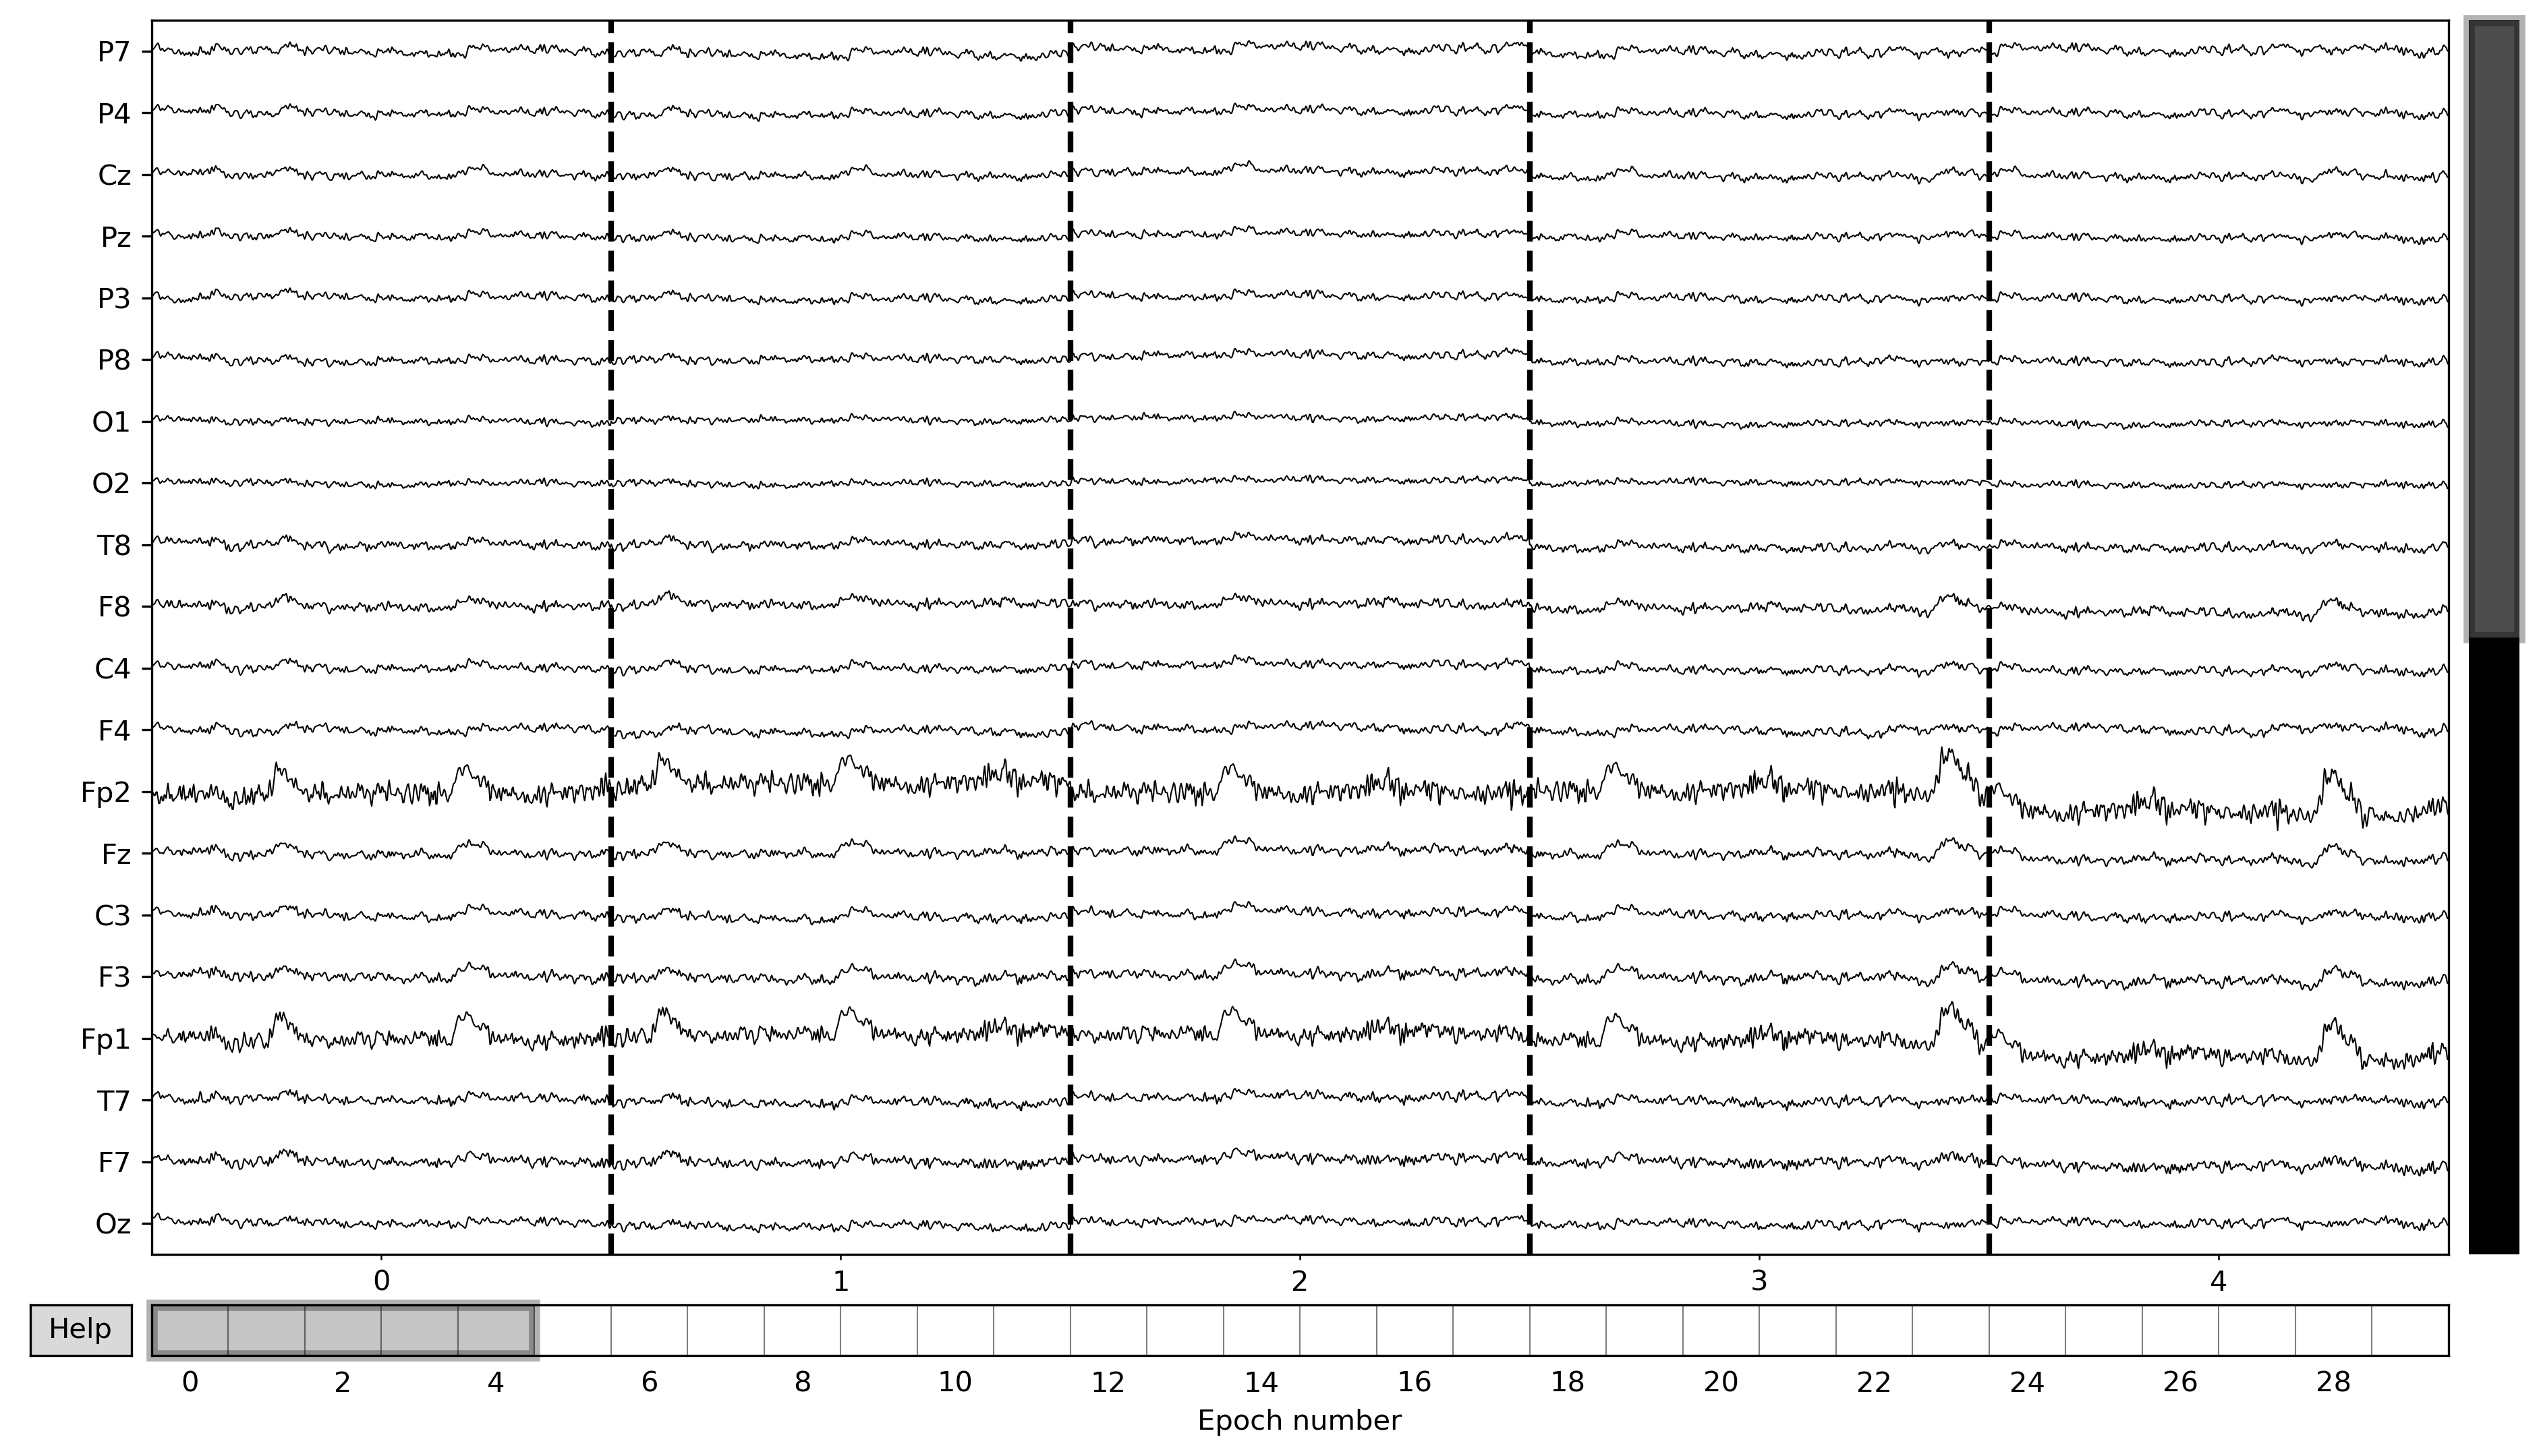

In [10]:
ica.exclude = ICs2remove[subj_idx]['srg'][session_idx]
srg_epochs_prepped = srg_epochs.copy()
ica.apply(srg_epochs_prepped)
srg_epochs_prepped.interpolate_bads()
srg_epochs_prepped.save(srg_epochs_prepped_fName, overwrite=True)
srg_epochs_prepped.plot(scalings=dict(eeg=1e-4, emg=5e-4), n_epochs=5, picks='all')  # visual inspection

## Step 3: generate motor epochs of 4 sorts and ICA fitting

In [24]:
events, events_id = mne.events_from_annotations(aligned_raw)
type_event_dict = {'push': 1, 'habd': 2, 'pull': 3, 'hadd': 4}
for epochs_type in type_event_dict.keys():
    exec('events_' + epochs_type + '= events[events[:,2]==2]')
    exec(epochs_type + '_epochs = mne.Epochs(aligned_raw, events_' + epochs_type + ', tmin=0.0, tmax=length_epochs + 1 / sfreq_eeg, reject=reject_criteria,\
         flat=flat_criteria, baseline=(0, 0), preload=True)')
    exec(epochs_type + '_epochs.save(' + epochs_type + '_epochs_fName, overwrite=True)')
    ica = ICA(n_components=0.99, random_state=97)
    exec('ica.fit(' + epochs_type +'_epochs)')
    exec('ica.plot_sources(' + epochs_type + '_epochs, stop=3, title="' + epochs_type + '"+"_ica")')
    exec('ica.plot_components(inst=' + epochs_type +'_epochs, title="' + epochs_type + '"+"_ica")')
    exec('ica.save(' + epochs_type + '_ica_fName)')

Used Annotations descriptions: ['1', '2', '3', '4']
Not setting metadata
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 1502 original time points ...
0 bad epochs dropped
Overwriting existing file.
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 20 components
Fitting ICA took 0.3s.
Not setting metadata
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Writing ICA solution to E:/masterSJTU/MultiEEGEMG_stroke\subj51\ica\subj51_iVC_s01_push_ica.fif...
Not setting metadata
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 1502 original time points ...
0 bad epochs dropped
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Se

## Step 4: ICA removal for motor epochs
**update ICs2remove before running this cell** 
<br>we are here, create a exec loop!

Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components
Interpolating bad channels
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors


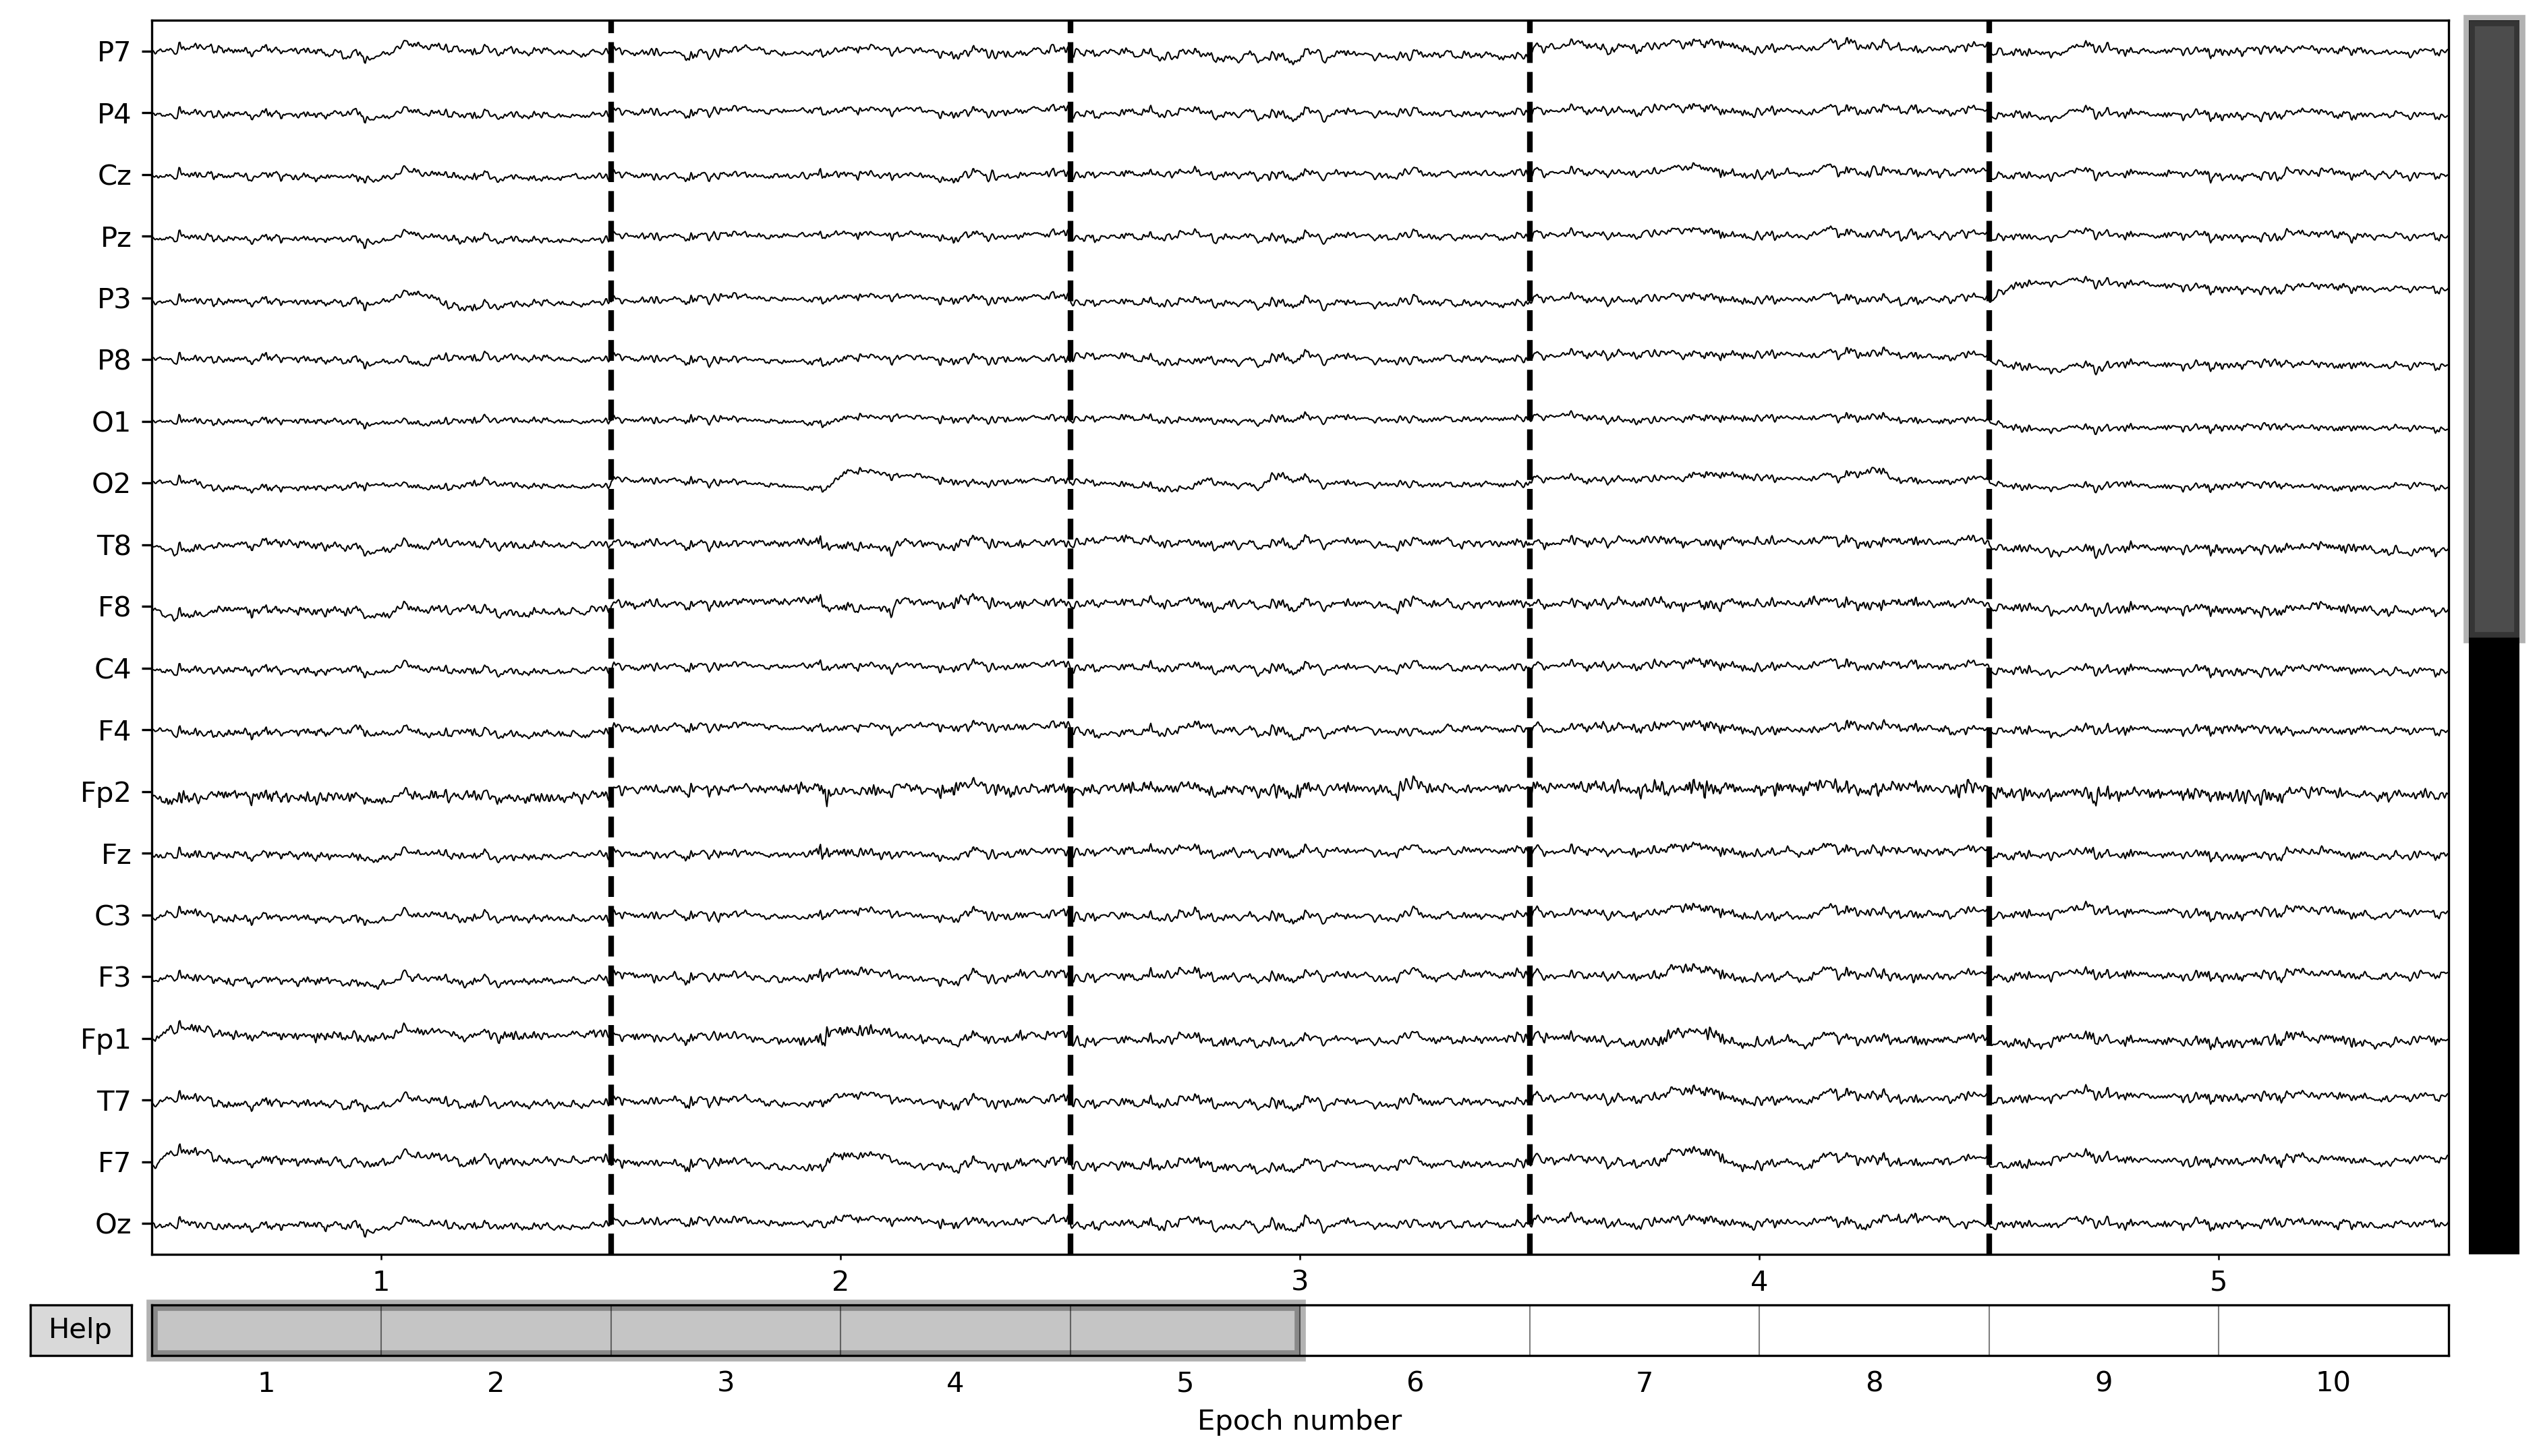

In [17]:
ica.exclude = ICs2remove[subj_idx]['push'][session_idx]
push_epochs_prepped = push_epochs.copy()
ica.apply(push_epochs_prepped)
push_epochs_prepped.interpolate_bads()
push_epochs_prepped.save(push_epochs_prepped_fName, overwrite=True)
push_epochs_prepped.plot(scalings=dict(eeg=1e-4, emg=5e-4), n_epochs=5, picks='all', title='push_epochs_prepped' )  # visual inspection

# Supplementary analysis
## EMG of healthy controls
## Conclusion: EMG during isokinetic movement in healthy controls include burst which maybe due to the change of electrode attachment caused by big range of motion. Thus, the bursts are regarded as artifacts.


Creating RawArray with float64 data, n_channels=8, n_times=210000
    Range : 0 ... 209999 =      0.000 ...   209.999 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 1321 samples (1.321 sec)



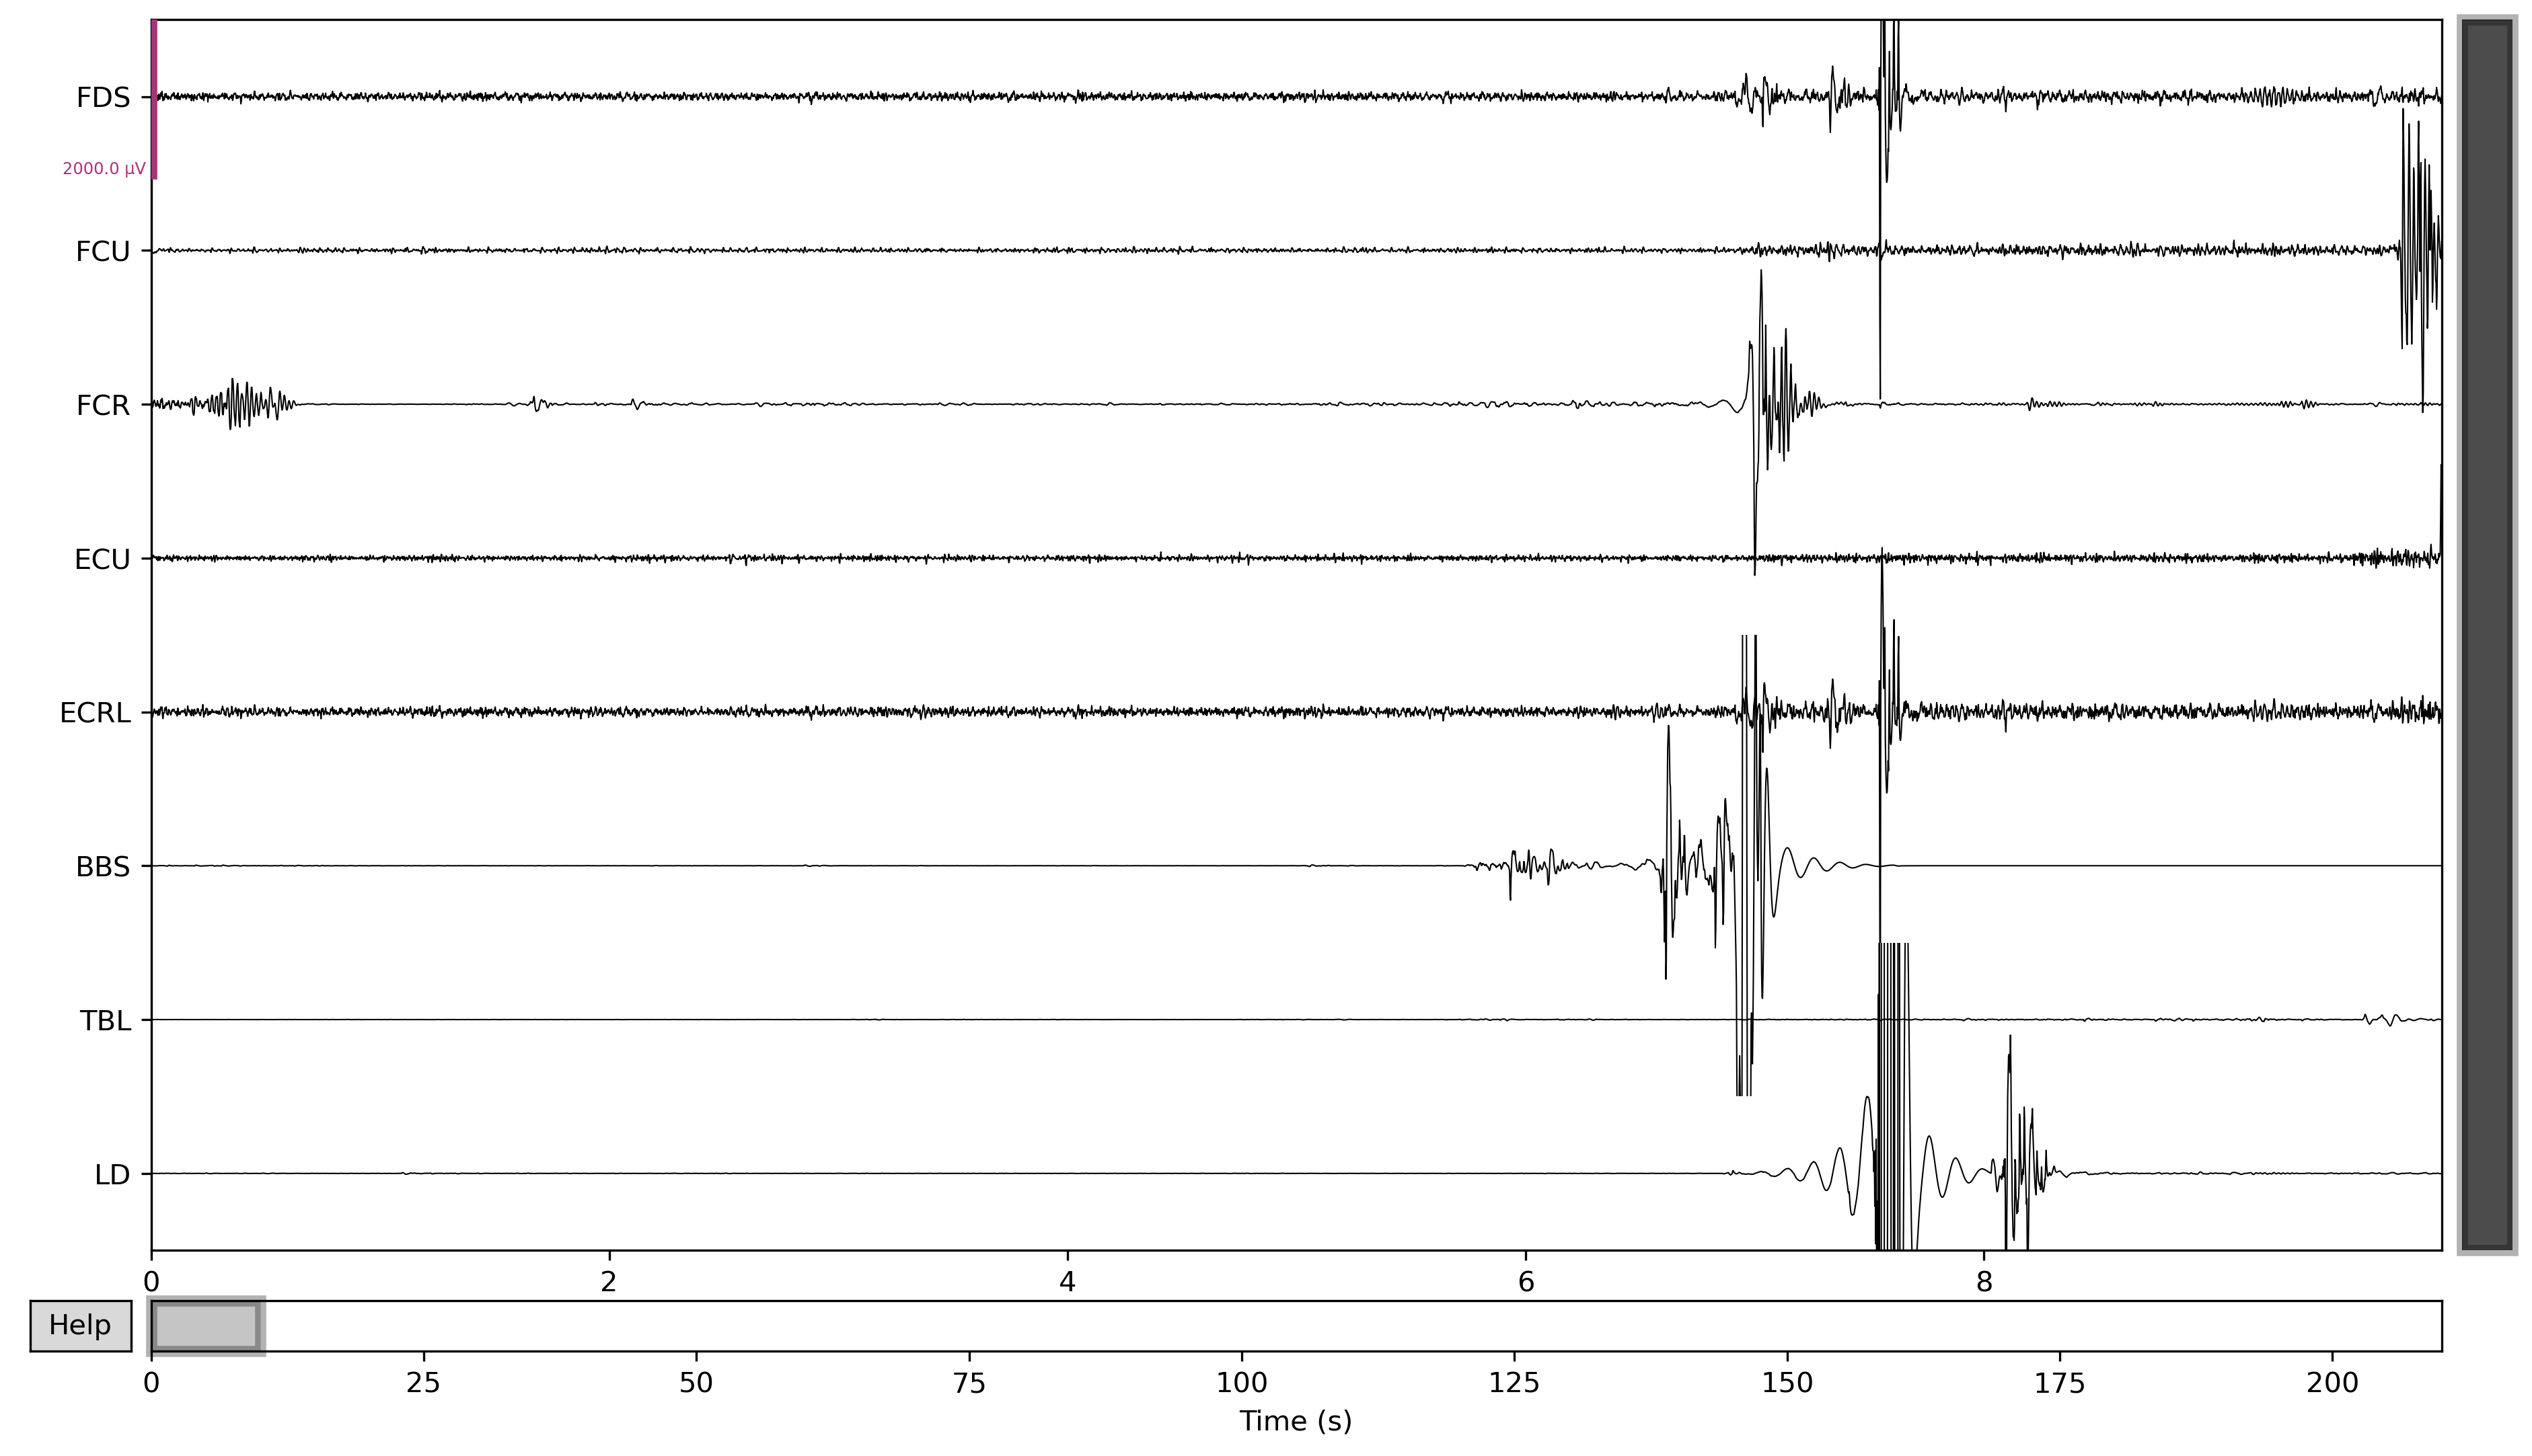

In [31]:
ch_types = ['emg'] * 8
ch_names = ['FDS', 'FCU', 'FCR', 'ECU', 'ECRL', 'BBS', 'TBL', 'LD']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq_emg, ch_types=ch_types)
emg_data = pd.read_csv(r'E:\masterSJTU\MultiEEGEMG_stroke\subj59\subj59_iVC_s01.txt', header=None, skiprows=3,
                       sep=' ', usecols=np.arange(0, 8), skipfooter=0, engine='python')
emg_data=emg_data.T / 1e6
emg_raw = mne.io.RawArray(emg_data, info)
emg_raw.filter(l_freq=10, h_freq=200, picks='all')
emg_raw.resample(sfreq=sfreq_eeg)
emg_raw.plot()